In [1]:

import pandas as pd
import numpy as np
from scipy.stats import skew
import warnings
import matplotlib
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet,Lasso, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
# from tabulate import tabulate
import seaborn as sns
# import xgboost as xgb


warnings.filterwarnings("ignore") 

%matplotlib inline

# full_quarter_df=pd.read_csv("new_full_quarterData.csv")
top_quarter_df=pd.read_csv("new_topsegments_quarterData.csv")

#Lets read the data
# train =full_quarter_df[20:38]
# test =full_quarter_df.head(20)

train = top_quarter_df.head(20)
test =  top_quarter_df[20:37]

pd.options.display.max_columns = 200  # None -> No Restrictions
pd.options.display.max_rows = 100    # None -> Be careful with this 
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

In [2]:
#Data cleansing
all_data = pd.concat((train,
                       test))

#log transform the target:
train['revenue'] = np.log1p(train['revenue'])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index  #Lets mark which features are very skewed.

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

# all_data = pd.concat([all_data,pd.get_dummies(all_data['citypair'], prefix='segment')],axis=1)
# all_data = pd.concat([all_data,pd.get_dummies(all_data['aircraft'], prefix='plane')],axis=1)

# all_data.drop(['citypair'],axis=1, inplace=True)
# all_data.drop(['aircraft'],axis=1, inplace=True)
      
all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(0)
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]

X_train.drop(['revenue'],axis=1, inplace=True)
X_test.drop(['revenue'],axis=1, inplace=True)

y = train['revenue']
X_train

,year,quarter,fuel_price,stock_price,operational_expense,HOU-DAL-Boeing 737-300_flights_flown,HOU-DAL-Boeing 737-300_passengers_carried,DAL-HOU-Boeing 737-300_flights_flown,DAL-HOU-Boeing 737-300_passengers_carried,BUR-OAK-Boeing 737-700/700LR/Max 7_flights_flown,BUR-OAK-Boeing 737-700/700LR/Max 7_passengers_carried,OAK-BUR-Boeing 737-700/700LR/Max 7_flights_flown,OAK-BUR-Boeing 737-700/700LR/Max 7_passengers_carried,BUR-LAS-Boeing 737-700/700LR/Max 7_flights_flown,BUR-LAS-Boeing 737-700/700LR/Max 7_passengers_carried,LAS-BUR-Boeing 737-700/700LR/Max 7_flights_flown,LAS-BUR-Boeing 737-700/700LR/Max 7_passengers_carried,MDW-LAS-Boeing 737-700/700LR/Max 7_flights_flown,MDW-LAS-Boeing 737-700/700LR/Max 7_passengers_carried,DAL-HOU-Boeing 737-700/700LR/Max 7_flights_flown,DAL-HOU-Boeing 737-700/700LR/Max 7_passengers_carried,PHX-SNA-Boeing 737-700/700LR/Max 7_flights_flown,PHX-SNA-Boeing 737-700/700LR/Max 7_passengers_carried,MDW-PHX-Boeing 737-700/700LR/Max 7_flights_flown,MDW-PHX-Boeing 737-700/700LR/Max 7_passengers_carried,LAS-MDW-Boeing 737-700/700LR/Max 7_flights_flown,LAS-MDW-Boeing 737-700/700LR/Max 7_passengers_carried,MDW-DEN-Boeing 737-700/700LR/Max 7_flights_flown,MDW-DEN-Boeing 737-700/700LR/Max 7_passengers_carried,HOU-DAL-Boeing 737-700/700LR/Max 7_flights_flown,HOU-DAL-Boeing 737-700/700LR/Max 7_passengers_carried,DAL-SAT-Boeing 737-700/700LR/Max 7_flights_flown,DAL-SAT-Boeing 737-700/700LR/Max 7_passengers_carried,SAN-LAS-Boeing 737-700/700LR/Max 7_flights_flown,SAN-LAS-Boeing 737-700/700LR/Max 7_passengers_carried,PHX-DEN-Boeing 737-700/700LR/Max 7_flights_flown,PHX-DEN-Boeing 737-700/700LR/Max 7_passengers_carried,LAS-SAN-Boeing 737-700/700LR/Max 7_flights_flown,LAS-SAN-Boeing 737-700/700LR/Max 7_passengers_carried,LAS-RNO-Boeing 737-700/700LR/Max 7_flights_flown,LAS-RNO-Boeing 737-700/700LR/Max 7_passengers_carried,RNO-LAS-Boeing 737-700/700LR/Max 7_flights_flown,RNO-LAS-Boeing 737-700/700LR/Max 7_passengers_carried,LAX-OAK-Boeing 737-700/700LR/Max 7_flights_flown,LAX-OAK-Boeing 737-700/700LR/Max 7_passengers_carried,MCI-MDW-Boeing 737-700/700LR/Max 7_flights_flown,MCI-MDW-Boeing 737-700/700LR/Max 7_passengers_carried,DAL-HOU-Boeing 737-500_flights_flown,DAL-HOU-Boeing 737-500_passengers_carried,HOU-DAL-Boeing 737-500_flights_flown,HOU-DAL-Boeing 737-500_passengers_carried,LAS-PHX-Boeing 737-700/700LR/Max 7_flights_flown,LAS-PHX-Boeing 737-700/700LR/Max 7_passengers_carried,DEN-MDW-Boeing 737-700/700LR/Max 7_flights_flown,DEN-MDW-Boeing 737-700/700LR/Max 7_passengers_carried,MDW-MCI-Boeing 737-700/700LR/Max 7_flights_flown,MDW-MCI-Boeing 737-700/700LR/Max 7_passengers_carried,SJC-SNA-Boeing 737-700/700LR/Max 7_flights_flown,SJC-SNA-Boeing 737-700/700LR/Max 7_passengers_carried,SNA-SJC-Boeing 737-700/700LR/Max 7_flights_flown,SNA-SJC-Boeing 737-700/700LR/Max 7_passengers_carried,OAK-SNA-Boeing 737-700/700LR/Max 7_flights_flown,OAK-SNA-Boeing 737-700/700LR/Max 7_passengers_carried,FLL-BWI-Boeing 737-700/700LR/Max 7_flights_flown,FLL-BWI-Boeing 737-700/700LR/Max 7_passengers_carried,MDW-MSP-Boeing 737-700/700LR/Max 7_flights_flown,MDW-MSP-Boeing 737-700/700LR/Max 7_passengers_carried,SNA-OAK-Boeing 737-700/700LR/Max 7_flights_flown,SNA-OAK-Boeing 737-700/700LR/Max 7_passengers_carried,BWI-FLL-Boeing 737-700/700LR/Max 7_flights_flown,BWI-FLL-Boeing 737-700/700LR/Max 7_passengers_carried,OAK-LAX-Boeing 737-700/700LR/Max 7_flights_flown,OAK-LAX-Boeing 737-700/700LR/Max 7_passengers_carried,SAN-OAK-Boeing 737-700/700LR/Max 7_flights_flown,SAN-OAK-Boeing 737-700/700LR/Max 7_passengers_carried,LAX-LAS-Boeing 737-700/700LR/Max 7_flights_flown,LAX-LAS-Boeing 737-700/700LR/Max 7_passengers_carried,DCA-MDW-Boeing 737-700/700LR/Max 7_flights_flown,DCA-MDW-Boeing 737-700/700LR/Max 7_passengers_carried,SMF-SAN-Boeing 737-700/700LR/Max 7_flights_flown,SMF-SAN-Boeing 737-700/700LR/Max 7_passengers_carried,PHX-DEN-Boeing 737-800_flights_flown,PHX-DEN-Boeing 737-800_passengers_carried,MDW-LAS-Boeing 737-800_flights_flown,MDW-LAS-B

In [3]:
print(X_train.shape)
print(X_test.shape)

(20, 99)
(17, 99)


In [4]:
def rmse_cv(model, dataset):
    rmse= np.sqrt(-cross_val_score(model, dataset, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

def outputPredictionToCSV(predictionData, filename):
    arr = test['year']
    arr2 = test['quarter']
#     arr3 = np.expm1(predictionData)
    arr3=predictionData
    df = pd.DataFrame(data=arr, columns = ["Year"])
    df.applymap(int) 
    
    df1 = pd.DataFrame(data=arr2, columns = ["Quarter"])
    df1.applymap(int)
    
    df2 = pd.DataFrame(data=arr3, columns = ['predict.revenue'])
        
    df4 = pd.concat([df,df1,df2], axis=1)
    dff = pd.DataFrame(data=df4) 
#     dff.to_csv(filename+".csv", index=False)
    

def printRMSE_MSE(modelName,model,trainData):
    print(modelName +" has RMSE of "+ str(rmse_cv(model,trainData).mean()))
    yHat= model.predict(trainData) 
    print(modelName + " has MSE on train data is: "+ str(mean_squared_error(y,yHat)))
    
def printActuals(predictionData):
    act_data = test
    act_data=act_data.reset_index(drop=True)
#     print(act_data)
    arr3 = np.expm1(predictionData)
    percentErrors =[]
    for x in range(len(act_data.revenue)):
#         print(act_data.revenue)
        
        percentError= (100*(abs(act_data.revenue[x]-arr3[x])/act_data.revenue[x]))
        print("Quarter : "+str(act_data.quarter[x])+" Year: "+str(act_data.year[x])+" : Actual: "+str(act_data.revenue[x])+" ,Prediction: "+str(arr3[x])+" ,Error: "+ str(percentError)+"%")
        percentErrors.append(percentError)
    print("Avg Percent Error is : "+str(sum(percentErrors) / len(percentErrors) ))
    
    
def printTopTenFeatures(model):
    import operator
    coeff_used = np.sum(model.coef_!=0)
    print("Number of Coeffients used: "+ str(coeff_used))
    coef_dict = {} 

    indexOfFeature =0

    for coef in model.coef_:
        if coef!=0: 
            coef_dict[X_train.columns[indexOfFeature]]=coef
        indexOfFeature+=1
    highestCoef_dict_sorted = sorted(coef_dict.items(), key=operator.itemgetter(1), reverse=True)[:5]
    print("Highest Coef: ")
    print(highestCoef_dict_sorted)
    lowestCoef_dict_sorted = sorted(coef_dict.items(), key=operator.itemgetter(1), reverse=False)[:5]
    print("Lowest Coef: ")
    print(lowestCoef_dict_sorted)
            
    

In [5]:
# ridge regression
modelForProblem1= Ridge(alpha=.1).fit(X_train, y)

printRMSE_MSE('ridge_regression_withGivenAlpha',modelForProblem1,X_train)

predictforModel1= modelForProblem1.predict(X_test)
outputPredictionToCSV(predictforModel1,'ridge_regression_withGivenAlpha_output')
print(X_train.shape)
printActuals(predictforModel1)
printTopTenFeatures(modelForProblem1)

ridge_regression_withGivenAlpha has RMSE of 0.6579858688328001
ridge_regression_withGivenAlpha has MSE on train data is: 3.731495896093312e-13
(20, 99)
Quarter : 1 Year: 2015 : Actual: 4414000 ,Prediction: 148047.2335938147 ,Error: 96.64596208441742%
Quarter : 2 Year: 2015 : Actual: 5111000 ,Prediction: 3129481.9030946074 ,Error: 38.76967514978268%
Quarter : 3 Year: 2015 : Actual: 5318000 ,Prediction: 5152956.964284344 ,Error: 3.1034794230097096%
Quarter : 4 Year: 2015 : Actual: 4977000 ,Prediction: 5698203.839468297 ,Error: 14.490734166531979%
Quarter : 1 Year: 2016 : Actual: 4826000 ,Prediction: 5910732.972593125 ,Error: 22.476853970019167%
Quarter : 2 Year: 2016 : Actual: 5384000 ,Prediction: 5042172.611947652 ,Error: 6.348948515088187%
Quarter : 3 Year: 2016 : Actual: 5139000 ,Prediction: 6350091.795831137 ,Error: 23.566682152775588%
Quarter : 4 Year: 2016 : Actual: 4940000 ,Prediction: 8351340.893404987 ,Error: 69.05548367216572%
Quarter : 1 Year: 2017 : Actual: 4854000 ,Predictio

In [6]:
# Find the best Alpha for a ridge regression and a lasso regression model.

alphas = [0.000005, 0.00005, 0.00001, 0.0005, 0.0001, 0.005, 0.05, 0.1, 0.3, 0.5, 1, 3, 5, 7, 8, 9,9.5, 10, 10.5, 11, 15, 30, 50, 75, 100]

cv_ridge = [rmse_cv(Ridge(alpha = alpha),X_train).mean() 
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
print("The best ridge regression : "+str(cv_ridge.min()) +" with Alpha as " + str(cv_ridge.idxmin()))
print("The top five are:\n"+ str(cv_ridge.sort_values().head(5)))



cv_lasso = [rmse_cv(Lasso(alpha = alpha),X_train).mean() 
            for alpha in alphas]
cv_lasso = pd.Series(cv_lasso, index = alphas)
print("\n\nThe best lasso regression : " +str(cv_lasso.min()) +" with Alpha as " + str(cv_lasso.idxmin()))
print("The top five are:\n"+ str(cv_lasso.sort_values().head(5)))

bestRidgeRegressionAlphaValue = cv_ridge.idxmin()
bestLassoRegressionAlphaValue = cv_lasso.idxmin()

The best ridge regression : 0.6572908791756025 with Alpha as 100.0
The top five are:
100.0    0.657
75.0     0.657
50.0     0.658
30.0     0.658
15.0     0.658
dtype: float64


The best lasso regression : 0.10705713996390195 with Alpha as 100.0
The top five are:
1.000e+02    0.107
7.500e+01    0.109
5.000e+01    0.116
3.000e+01    0.124
5.000e-04    0.142
dtype: float64


In [7]:
# ridge regression with best alpha
modelForProblem2= Ridge(alpha = bestRidgeRegressionAlphaValue).fit(X_train, y)

printRMSE_MSE('ridge_regression_withBestAlpha',modelForProblem2,X_train)

predictforModel2= modelForProblem2.predict(X_test)
outputPredictionToCSV(predictforModel2,'ridge_regression_WithBestAlpha_output')
printActuals(predictforModel2)
printTopTenFeatures(modelForProblem2)

ridge_regression_withBestAlpha has RMSE of 0.6572908791756025
ridge_regression_withBestAlpha has MSE on train data is: 3.488596872343861e-07
Quarter : 1 Year: 2015 : Actual: 4414000 ,Prediction: 147001.83479120058 ,Error: 96.66964579086542%
Quarter : 2 Year: 2015 : Actual: 5111000 ,Prediction: 3138894.7536977334 ,Error: 38.58550667779821%
Quarter : 3 Year: 2015 : Actual: 5318000 ,Prediction: 5152102.361211521 ,Error: 3.119549431900703%
Quarter : 4 Year: 2015 : Actual: 4977000 ,Prediction: 5709171.7956150565 ,Error: 14.711107004521931%
Quarter : 1 Year: 2016 : Actual: 4826000 ,Prediction: 5908941.705784706 ,Error: 22.43973696197071%
Quarter : 2 Year: 2016 : Actual: 5384000 ,Prediction: 5062172.558880036 ,Error: 5.977478475482248%
Quarter : 3 Year: 2016 : Actual: 5139000 ,Prediction: 6360839.35848769 ,Error: 23.775819390692547%
Quarter : 4 Year: 2016 : Actual: 4940000 ,Prediction: 8326569.138137269 ,Error: 68.55403113638197%
Quarter : 1 Year: 2017 : Actual: 4854000 ,Prediction: 6936302.0

In [8]:
# Lasso with best alpha
modelForProblem2b= Lasso(alpha = bestLassoRegressionAlphaValue).fit(X_train, y)

printRMSE_MSE('lasso_regression_withBestAlpha',modelForProblem2b,X_train)

predictforModel2b= modelForProblem2b.predict(X_test)
outputPredictionToCSV(predictforModel2b,'lasso_regression_WithBestAlpha_output')
printActuals(predictforModel2b)
printTopTenFeatures(modelForProblem2b)

lasso_regression_withBestAlpha has RMSE of 0.10705713996390195
lasso_regression_withBestAlpha has MSE on train data is: 0.0022775002212573163
Quarter : 1 Year: 2015 : Actual: 4414000 ,Prediction: 3603668.4275247017 ,Error: 18.35821414760531%
Quarter : 2 Year: 2015 : Actual: 5111000 ,Prediction: 4267790.366117214 ,Error: 16.497938444194602%
Quarter : 3 Year: 2015 : Actual: 5318000 ,Prediction: 4567148.256420827 ,Error: 14.119062496787768%
Quarter : 4 Year: 2015 : Actual: 4977000 ,Prediction: 4716575.103570579 ,Error: 5.232567740193317%
Quarter : 1 Year: 2016 : Actual: 4826000 ,Prediction: 4452036.998283108 ,Error: 7.74892253868405%
Quarter : 2 Year: 2016 : Actual: 5384000 ,Prediction: 4724022.552766088 ,Error: 12.258124948623914%
Quarter : 3 Year: 2016 : Actual: 5139000 ,Prediction: 5300314.204096456 ,Error: 3.1390193441614334%
Quarter : 4 Year: 2016 : Actual: 4940000 ,Prediction: 4924682.11663798 ,Error: 0.31007861056721386%
Quarter : 1 Year: 2017 : Actual: 4854000 ,Prediction: 4916024

       Alpha  None Zero Coefs
0  5.000e-06               67
1  5.000e-05               48
2  1.000e-05               66
3  5.000e-04               36
4  1.000e-04               43
5  5.000e-03               32
6  5.000e-02               22
7  1.000e-01               19
8  3.000e-01               16
9  5.000e-01               14


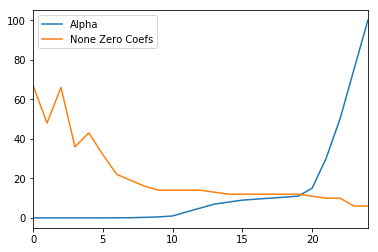

In [9]:
coefDF=[]
alphaDF=[]

for x in alphas:
    temp_lasso= Lasso(alpha = x).fit(X_train, y)
    coef = pd.Series(temp_lasso.coef_, index = X_train.columns)
    coefDF.append(sum(coef != 0))
    alphaDF.append(x)

dfAlpha =pd.DataFrame(data=alphaDF, columns = ['Alpha'])
dfCoef =pd.DataFrame(data=coefDF, columns = ['None Zero Coefs'])

dff2= pd.concat([dfAlpha,dfCoef], axis=1)

print(dff2.head(10))

plotThis = pd.DataFrame(data=dff2)
plotThis.plot()

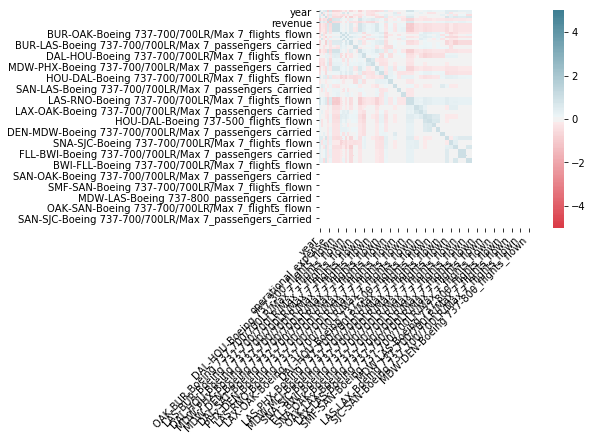

In [10]:
corr = train.corr()
ax = sns.heatmap(
    corr, 
    vmin=-5, vmax=5, center=0,
    cmap=sns.diverging_palette(10, 220, sep=5, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);